In [11]:
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
from adjustText import adjust_text

In [12]:
con = duckdb.connect("../dev.duckdb")

prices = con.execute("""
    SELECT *
    FROM main_mart.commodity_price_change_from_baseline
""").df()

print(prices)

       commodity_name unit_amount price_date   price  baseline_price  \
0    baby milk powder      400 gm 2023-11-01  38.667           36.11   
1    baby milk powder      400 gm 2023-12-01  50.000           36.11   
2    baby milk powder      400 gm 2024-01-01  45.000           36.11   
3    baby milk powder      400 gm 2024-02-01  60.000           36.11   
4    baby milk powder      400 gm 2024-03-01  55.000           36.11   
..                ...         ...        ...     ...             ...   
961         zucchinis        1 kg 2025-05-01  34.063            3.88   
962         zucchinis        1 kg 2025-06-01  36.444            3.88   
963         zucchinis        1 kg 2025-07-01  45.571            3.88   
964         zucchinis        1 kg 2025-08-01  52.143            3.88   
965         zucchinis        1 kg 2025-09-01  46.000            3.88   

     pct_change_from_baseline  
0                      3766.7  
1                      4900.0  
2                      4400.0  
3      

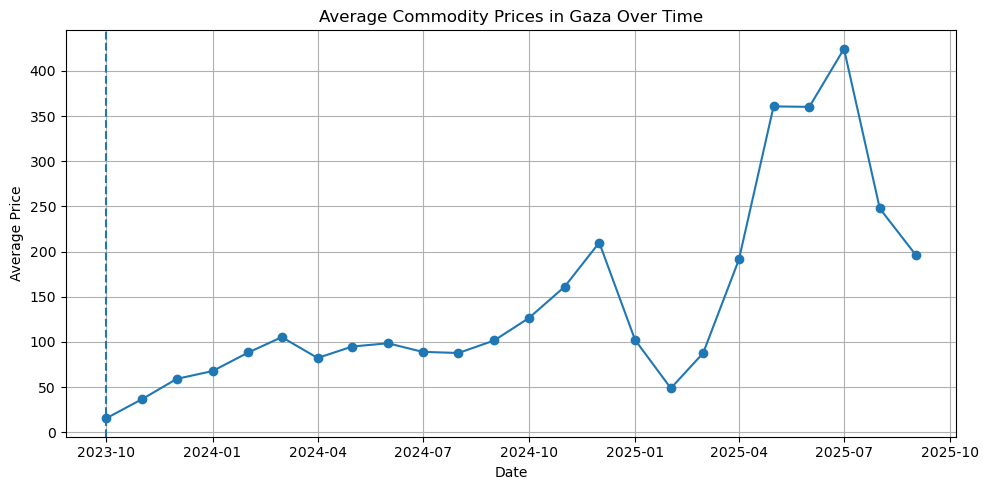

In [13]:
df = con.execute("""
    SELECT
        price_date,
        AVG(price) AS avg_price
    FROM main_mart.fct_commodity_prices_gaza
    GROUP BY price_date
    ORDER BY price_date
""").df()

plt.figure(figsize=(10, 5))
plt.plot(df["price_date"], df["avg_price"], marker='o')
plt.axvline(pd.to_datetime("2023-10-01"), linestyle="--")
plt.title("Average Commodity Prices in Gaza Over Time")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

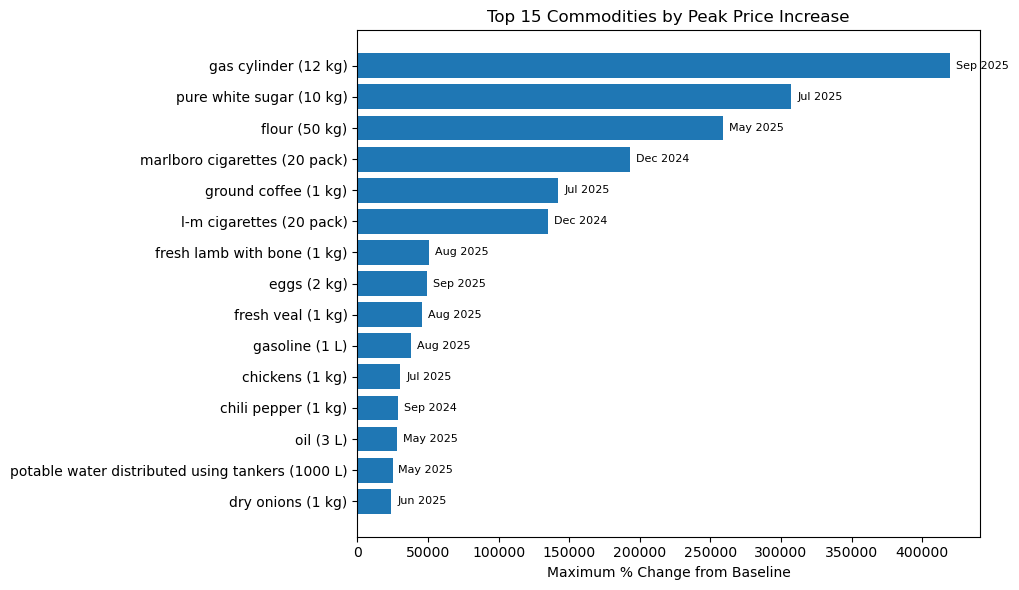

In [14]:
df = con.execute("""
    WITH ranked AS
    (
    SELECT
        commodity_name,
        unit_amount,
        baseline_price,
        price,
        pct_change_from_baseline,
        price_date,
        ROW_NUMBER() OVER (PARTITION BY commodity_name, unit_amount ORDER BY pct_change_from_baseline DESC) AS rn
    FROM main_mart.commodity_price_change_from_baseline
    )

    SELECT
        commodity_name,
        unit_amount,
        baseline_price,
        price AS max_price,
        pct_change_from_baseline AS commodity_max_pct_change,
        price_date AS max_price_date
    FROM ranked
    WHERE rn = 1
    ORDER BY pct_change_from_baseline DESC
    LIMIT 15
""").df()

plt.figure(figsize=(10, 6))
plt.barh(df["commodity_name"] + " (" + df["unit_amount"] + ")", df["commodity_max_pct_change"])
plt.gca().invert_yaxis()
plt.title("Top 15 Commodities by Peak Price Increase")
plt.xlabel("Maximum % Change from Baseline")
plt.tight_layout()

offset = df["commodity_max_pct_change"].max() * 0.01
for i, value in enumerate(df["max_price_date"]):
    plt.text(df["commodity_max_pct_change"].iloc[i] + offset, i, value.strftime("%b %Y"), va="center", fontsize=8)

plt.show()

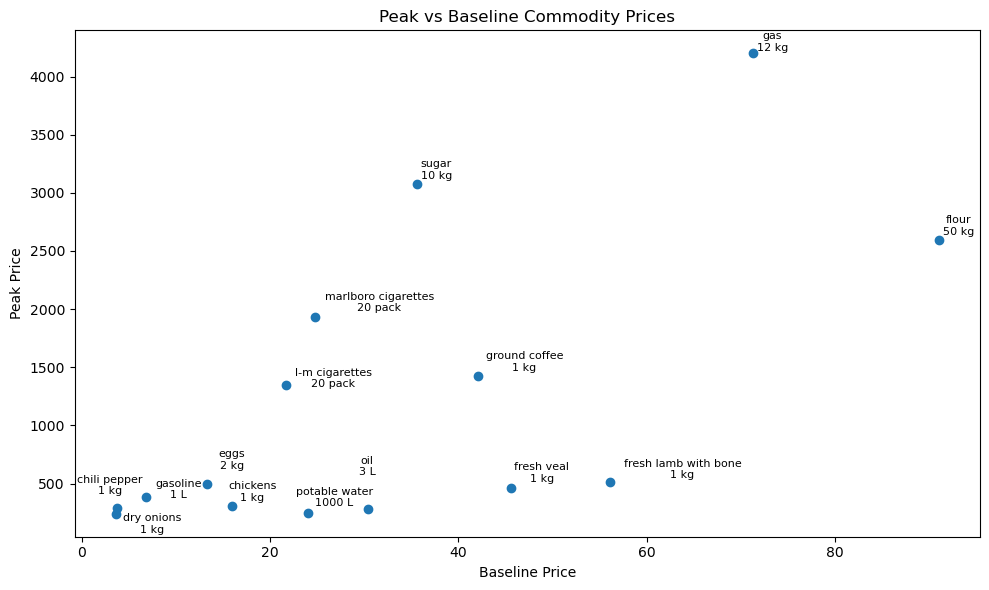

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(df["baseline_price"], df["max_price"])

df['scatter_labels'] = (
    df['commodity_name']
    .str.replace("pure white ", "")
    .str.replace(" cylinder", "")
    .str.replace(" distributed using tankers", "")
    + "\n" + df['unit_amount']
    .str.replace("liters", "L")

)

texts = []
for i in range(len(df)):
    texts.append(
    plt.text(
        df["baseline_price"].iloc[i],
        df["max_price"].iloc[i],
        df['scatter_labels'].iloc[i],
        fontsize=8
    ))

adjust_text(
    texts,
    force_text=(0.1, 0.1),
    force_points=(0.1, 0.1),
    expand_text=(1.05, 1.1),
    expand_points=(1.05, 1.1)
)

plt.xlabel("Baseline Price")
plt.ylabel("Peak Price")
plt.title("Peak vs Baseline Commodity Prices")
plt.tight_layout()
plt.show()